In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import warnings
from time import time
import plotly.graph_objects as go
from itertools import product
from tqdm import tqdm
from scipy.interpolate import CubicSpline 

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) 

warnings.simplefilter('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Simulation : data generation

In [3]:
S0 = 100
T = 1
r = 0.03

In [4]:
def black_scholes_price(x1, T, S, x2, r=0.03):
    vol_ref = 0.2
    vol = vol_ref * np.exp(x2)
    
    d_plus = (x1 + r*T) / (vol*np.sqrt(T)) + 1/2 * vol * np.sqrt(T)
    d_minus = (x1 + r*T) / (vol*np.sqrt(T)) - 1/2 * vol * np.sqrt(T)
    
    return S * norm.cdf(d_plus) - S * np.exp(-x1) * np.exp(-r*T) * norm.cdf(d_minus)

def delta(x1, T, S, x2, r=0.03):
    vol_ref = 0.2
    vol = vol_ref * np.exp(x2)
    
    d_plus = (x1 + r*T) / (vol*np.sqrt(T)) + 1/2 * vol * np.sqrt(T)
    d_minus = (x1 + r*T) / (vol*np.sqrt(T)) - 1/2 * vol * np.sqrt(T)
    
    return (S/vol*np.sqrt(T))* norm.pdf(d_plus) - S  * np.exp(-r*T) * np.exp(-x1)*((1/(vol*np.sqrt(T)))*norm.pdf(d_minus)  -norm.cdf(d_minus) )

In [5]:
class Spline2d:
    def __init__(self,x1, x2):
        self.x1 = x1
        self.x2 = x2

    
    def computes_spline_1D(self, x1_val, x2_val):
        Splines = {}
        xx1, xx2 = np.meshgrid(self.x1, self.x2)
        
        r_values  = black_scholes_price(xx1, T, S0, xx2, r=0.03)
        
        for i, u in enumerate(self.x1):
            Splines[u] = CubicSpline(self.x2, r_values[:, i], bc_type=((2, 0), (2, 0)))

        t = np.array([Splines[u](x2_val)  for u in self.x1])
        
        Spline_f = CubicSpline(self.x1, t, bc_type=((2, 0), (2, 0)))
        
        return Spline_f(x1_val)
    
    def computes_spline(self, x1_val, x2_val):
        #assert len(x1_val) == len(x2_val)
        surface_spline = np.zeros((len(x2_val), len(x1_val)))
        
        for i in tqdm(range(len(x2_val)), disable=True): 
            surface_spline[i, :] = self.computes_spline_1D(x1_val, x2_val[i])
            
        return surface_spline
    
    def computes_value(self, x1_val, x2_val):
        #surface_spline = np.zeros((len(x2_val), len(x1_val)))
        
        return self.computes_spline_1D([x1_val], x2_val)[0]

In [6]:
# Fitting the spline

x2_vals = np.linspace(-6, 6, 10)
x1_vals = np.linspace(-6, 6, 10)
x1_vals = np.insert(np.append(x1_vals, 10), 0, -10)
x2_vals = np.insert(np.append(x2_vals, 10), 0, -10)

splines = Spline2d(x1_vals, x2_vals)

# Testing the spline

x1_test = 2 # np.linspace(-10, 10, 50)
x2_test = 2 # np.linspace(-10, 10, 50)

cs_spline_approx = splines.computes_value(x1_test, x2_test)

x1_test = np.linspace(-10, 10, 10)
x2_test = np.linspace(-10, 10, 10)

cs_spline_approx = splines.computes_spline(x1_test, x2_test)

In [7]:
np.diag(cs_spline_approx)

array([ 0.00000000e+00, -1.37667092e-01,  8.06060879e-02,  7.15046056e-16,
       -4.04331298e+00,  6.79483432e+01,  9.99189484e+01,  9.99932114e+01,
        9.99979757e+01,  1.00000000e+02])

In [8]:
fig = go.Figure(data=[go.Surface(z=cs_spline_approx, x=x1_test, y=x2_test)])

fig.update_layout(title='Surface of the spline Prices', autosize=True,
                  width=500, height=500,
                  xaxis_title="K")

fig.show()

In [9]:
def simulation(S0, T, r, n_simulations, range_x1=(-1, 1), range_x2=(-1, 1), vol_ref=0.2):
    
    x1 = np.random.uniform(range_x1[0], range_x1[1], size=n_simulations)
    x2 = np.random.uniform(range_x2[0], range_x2[1], size=n_simulations)
    
    K = S0 * np.exp(-x1)
    vol = vol_ref * np.exp(x2)
    
    S_final = S0*np.exp((r - 0.5*(vol**2))*T + vol*np.sqrt(T)*np.random.normal(size=n_simulations))
    Payoff = np.maximum(0, S_final - K)
    
    Residual = []
    
    for i in tqdm(range(n_simulations)):
        Residual.append(Payoff[i] - splines.computes_value(x1[i], x2[i]))
    
    dataframe = pd.DataFrame({'x1': x1, 'x2': x2, 'Residual' : Residual})
    
    return dataframe

In [10]:
class BlackScholesDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#### Function that generates the data in the proper format

In [11]:
def generate_train_data(S0, T, r, n_simulations, BATCH_SIZE, range_x1=(-1, 1), range_x2=(-1, 1)):
    
    n_simulations = int(n_simulations * 1.2) # Additional simulations for the validation_data
    
    data = simulation(S0, T, r, n_simulations, range_x1, range_x2)
    
    y = data.Residual
    X = data.drop(columns='Residual')
    
    # Train - val
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69)
    
    scaler = MinMaxScaler()
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    
    y_train, y_val = y_train.astype(float), y_val.astype(float)
    
    train_dataset = BlackScholesDataset(torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(y_train).type(torch.float32))
    val_dataset = BlackScholesDataset(torch.from_numpy(X_val).type(torch.float32), torch.from_numpy(y_val).type(torch.float32))
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
    
    return train_loader, val_loader, scaler


In [12]:
def generate_test_data(S0, T, r, n_simulations, scaler, range_x1=(-3, 3), range_x2=(-3, 3)):
    data = simulation(S0, T, r, n_simulations, range_x1, range_x2)
    
    y = data.Residual
    X = data.drop(columns='Residual')
    
    #X_test = scaler.transform(X)
    X_test, y_test = np.array(X), np.array(y)
    
    y_test = y_test.astype(float)
    
    test_dataset = BlackScholesDataset(torch.from_numpy(X_test).type(torch.float32), torch.from_numpy(y_test).type(torch.float32))
    
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)
    
    return test_loader

In [13]:
S0 = 100
T = 1
r = 0.03


n_train_simulations = 400 ** 2
n_test_simulations = 50 ** 2

BATCH_SIZE = 2 ** 10

train_range = (-4, 4)
test_range = (-6, 6)

train_loader, val_loader, scaler = generate_train_data(S0, T, r, n_train_simulations, BATCH_SIZE, range_x1=train_range, range_x2=train_range)
test_loader = generate_test_data(S0, T, r, n_test_simulations, scaler, range_x1=test_range, range_x2=test_range)

print("Batch size :", BATCH_SIZE)

100%|██████████████████████████████████████| 2500/2500 [00:03<00:00, 769.11it/s]

Batch size : 1024


## Neural network

In [14]:
try:
    device = torch.device("mps")
    print('Using MPS')
except RuntimeError:
    try:
        device = torch.device("cuda")
        print("Using CUDA")
    except RuntimeError:
        device = torch.device("cpu")
        print('Using CPU')

Using MPS


In [15]:
device = torch.device("cpu")
device

device(type='cpu')

In [16]:
NUM_FEATURES = 2 #len(X.columns)

On définit la CRL :

(Source : https://github.com/JeremyLinux/PyTorch-Radial-Basis-Function-Layer/blob/master/Torch%20RBF/torch_rbf.py)

In [17]:
def tau_c(x, l, u):
    num = u * torch.exp(x) + l * torch.exp(-x)
    denom = torch.exp(x) + torch.exp(-x)
    return num/denom

In [18]:
class weightConstraint():
    def __init__(self, range_c, min_w):
        self.range_c = range_c
        self.min_w = min_w
    
    def __call__(self, module):
        if hasattr(module, 'centres'):
            c = module.centres.data
            #c = tau_c(c, self.range_c[0], self.range_c[1])
            c = c.clamp(self.range_c[0], self.range_c[1])
            module.centres.data = c
        
        if hasattr(module, 'widths'):
            
            delta = torch.min(model.CRL.centres - model.CRL.range_c[0], model.CRL.range_c[1] - model.CRL.centres)
            u_scaled = delta / model.CRL.alpha
            
            w = module.widths.data
            #w = tau_c(w, self.min_w, 1)
            w = w.clamp(self.min_w, 2)
            module.widths.data = w

In [19]:
class RBF(nn.Module):
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}||^2 / s_{i}^2)
    Arguments:
        in_features: size of each input sample
        out_features: size of each output sample
    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, out_features) where N is an arbitrary batch size
    Attributes:
        centres: the learnable centres of shape (out_features, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.
        
        log_sigmas: logarithm of the learnable scaling factors of shape (out_features).
        
        basis_func: the radial basis function used to transform the scaled
            distances.
    """

    def __init__(self, in_features, out_features, basis_func, range_c=(-4, 4), min_w=0.1, alpha=3):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centres = nn.Parameter(torch.Tensor(out_features, in_features))
        self.widths = nn.Parameter(torch.Tensor(out_features, in_features))
        
        self.basis_func = basis_func
        self.range_c = range_c
        self.min_w = min_w
        self.alpha = alpha
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.centres, self.range_c[0], self.range_c[1])
        nn.init.uniform_(self.widths, self.min_w, 10 * self.min_w)

    def forward(self, input):
        size = (input.size(0), self.out_features, self.in_features)
        x = input.unsqueeze(1).expand(size)
        
        constraints = weightConstraint(self.range_c, self.min_w)
        self = self.apply(constraints)
        
        c = self.centres.unsqueeze(0).expand(size)
        
        distances = (x - c).pow(2) / self.widths.pow(2).unsqueeze(0)
        distances = distances.sum(-1)
        return self.basis_func(-distances)

In [46]:
class BlackScholesRegression(nn.Module):
    def __init__(self, num_features, range_c):
        super(BlackScholesRegression, self).__init__()
        n_nodes = 100
        self.CRL = RBF(num_features, n_nodes, basis_func=torch.exp, range_c=range_c)
        self.layer_out = nn.Linear(n_nodes, 1, bias=False)
        #self.activation = nn.LeakyReLU()
        
    def forward(self, inputs):
        x = self.CRL(inputs)
        #x = self.activation(x)
        x = self.layer_out(x)
        return x

    def predict(self, test_inputs):
        x = self.CRL(test_inputs)
        #x = self.activation(x)
        x = self.layer_out(x)
        return x

### Training the model

In [47]:
train_range

(-4, 4)

In [55]:
model = BlackScholesRegression(NUM_FEATURES, train_range)
model.to(device)

BlackScholesRegression(
  (CRL): RBF()
  (layer_out): Linear(in_features=100, out_features=1, bias=False)
)

In [56]:
loss_stats = {
    'train': [],
    "val": []
}

In [57]:
EPOCHS = 500
LEARNING_RATE = 1e-3

In [58]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [59]:
print("Begin training.")

for e in range(1, EPOCHS+1):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.
Epoch 001: | Train Loss: 111803.99375 | Val Loss: 3034480.16717
Epoch 002: | Train Loss: 111795.98795 | Val Loss: 3034475.81547
Epoch 003: | Train Loss: 111781.84286 | Val Loss: 3034467.83027
Epoch 004: | Train Loss: 111762.24727 | Val Loss: 3034456.10524
Epoch 005: | Train Loss: 111736.82659 | Val Loss: 3034438.14421
Epoch 006: | Train Loss: 111706.71228 | Val Loss: 3034418.80343
Epoch 007: | Train Loss: 111675.47899 | Val Loss: 3034395.27596
Epoch 008: | Train Loss: 111642.12027 | Val Loss: 3034369.49607
Epoch 009: | Train Loss: 111609.20285 | Val Loss: 3034341.56777
Epoch 010: | Train Loss: 111577.62060 | Val Loss: 3034315.64644
Epoch 011: | Train Loss: 111547.74453 | Val Loss: 3034290.34605
Epoch 012: | Train Loss: 111520.09053 | Val Loss: 3034266.10078
Epoch 013: | Train Loss: 111495.13351 | Val Loss: 3034242.99450
Epoch 014: | Train Loss: 111471.78606 | Val Loss: 3034220.30953
Epoch 015: | Train Loss: 111449.87174 | Val Loss: 3034198.14481
Epoch 016: | Train Loss:

Epoch 129: | Train Loss: 110692.43706 | Val Loss: 3033867.19543
Epoch 130: | Train Loss: 110691.66231 | Val Loss: 3033871.55278
Epoch 131: | Train Loss: 110689.38079 | Val Loss: 3033872.79341
Epoch 132: | Train Loss: 110688.20581 | Val Loss: 3033875.17601
Epoch 133: | Train Loss: 110686.76911 | Val Loss: 3033874.71680
Epoch 134: | Train Loss: 110685.35622 | Val Loss: 3033878.75113
Epoch 135: | Train Loss: 110684.44958 | Val Loss: 3033877.40750
Epoch 136: | Train Loss: 110683.14723 | Val Loss: 3033882.52164
Epoch 137: | Train Loss: 110681.16497 | Val Loss: 3033879.73902
Epoch 138: | Train Loss: 110680.52763 | Val Loss: 3033882.12320
Epoch 139: | Train Loss: 110679.38283 | Val Loss: 3033878.62726
Epoch 140: | Train Loss: 110677.44111 | Val Loss: 3033878.24894
Epoch 141: | Train Loss: 110676.92852 | Val Loss: 3033882.57536
Epoch 142: | Train Loss: 110675.73654 | Val Loss: 3033882.33756
Epoch 143: | Train Loss: 110674.44808 | Val Loss: 3033884.06032
Epoch 144: | Train Loss: 110673.01307 | 

Epoch 258: | Train Loss: 110608.68926 | Val Loss: 3033985.91023
Epoch 259: | Train Loss: 110608.09812 | Val Loss: 3033985.52510
Epoch 260: | Train Loss: 110606.97324 | Val Loss: 3033991.63989
Epoch 261: | Train Loss: 110606.62412 | Val Loss: 3033990.89497
Epoch 262: | Train Loss: 110606.12854 | Val Loss: 3033989.74155
Epoch 263: | Train Loss: 110606.10369 | Val Loss: 3033988.57200
Epoch 264: | Train Loss: 110606.23971 | Val Loss: 3033989.13183
Epoch 265: | Train Loss: 110605.56415 | Val Loss: 3033993.74974
Epoch 266: | Train Loss: 110605.01253 | Val Loss: 3033995.69508
Epoch 267: | Train Loss: 110604.81984 | Val Loss: 3033999.49083
Epoch 268: | Train Loss: 110604.94013 | Val Loss: 3034000.29059
Epoch 269: | Train Loss: 110604.51888 | Val Loss: 3034013.03345
Epoch 270: | Train Loss: 110603.77651 | Val Loss: 3033994.63017
Epoch 271: | Train Loss: 110603.31666 | Val Loss: 3034006.66929
Epoch 272: | Train Loss: 110603.42094 | Val Loss: 3034001.60724
Epoch 273: | Train Loss: 110602.60559 | 

KeyboardInterrupt: 

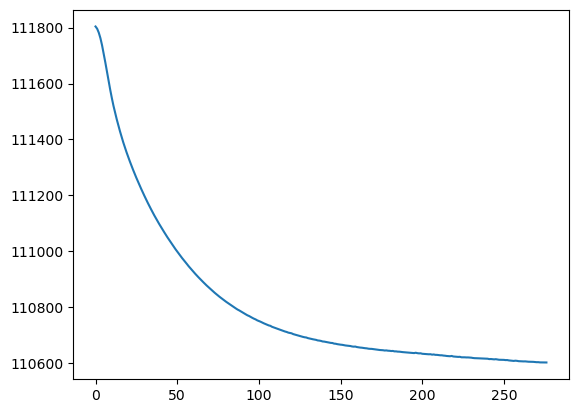

In [61]:
plt.plot(loss_stats['train'])

### Plotting the results

In [62]:
def black_scholes_price(x1, T, S, x2, r=0.03):
    vol_ref = 0.2
    vol = vol_ref * np.exp(x2)
    
    d_plus = (x1 + r*T) / (vol*np.sqrt(T)) + 1/2 * vol * np.sqrt(T)
    d_minus = (x1 + r*T) / (vol*np.sqrt(T)) - 1/2 * vol * np.sqrt(T)
    
    return S * norm.cdf(d_plus) - S * np.exp(-x1) * np.exp(-r*T) * norm.cdf(d_minus)

In [66]:
S0 = 100
vol_ref = .2
r = 0.03
T = 1

n_x1_points = 300
n_x2_points = 300

x1_values = np.linspace(test_range[0], test_range[1], n_x1_points)
x2_values = np.linspace(test_range[0], test_range[1], n_x2_points)

K_values = S0 * np.exp(-x1_values)
vol_values = vol_ref * np.exp(x2_values)

x_mesh = np.array(list(product(x1_values, x2_values))).astype(float)

bs_call_price = black_scholes_price(x_mesh[:, 0], T, S0, x_mesh[:, 1], r=0.03).reshape((n_x1_points, n_x2_points)).T

In [69]:
fig = go.Figure(data=[go.Surface(z=bs_call_price, x=x1_values, y=x2_values)])

fig.update_layout(title='Surface of true BS Call Prices', autosize=True,
                  width=700, height=700,
                  xaxis_title="K",)

fig.show()

#### Predicting the residuals

In [70]:
S0 = 100
vol_ref = 0.2
r = 0.03
T = 1

n_x1_points = 100
n_x2_points = 100

x1_values = np.linspace(test_range[0], test_range[1], n_x1_points)
x2_values = np.linspace(test_range[0], test_range[1], n_x2_points)

K_values = S0 * np.exp(x1_values)
vol_values = vol_ref * np.exp(x2_values)

X_test = np.array(list(product(x1_values, x2_values))).astype('float32')

y_test_pred = model.predict(torch.from_numpy(X_test).to(device)).cpu().detach().numpy()

y_test_pred = y_test_pred.reshape((n_x1_points, n_x2_points)).T


In [71]:
fig = go.Figure(data=[go.Surface(z=y_test_pred, x=x1_values, y=x2_values)])

fig.update_layout(title='Surface of predicted residuals', autosize=True,
                  width=700, height=700,
                  xaxis_title="K",)

fig.show()

In [39]:
model.CRL.widths

Parameter containing:
tensor([[1.9545, 0.1181],
        [0.5299, 0.4671],
        [0.2018, 0.3632],
        [0.1000, 0.1680],
        [0.4190, 0.6152],
        [0.1303, 0.4979],
        [1.2670, 0.1044],
        [0.5267, 0.2237],
        [0.9063, 0.3363],
        [1.9776, 0.8005],
        [1.9685, 1.2905],
        [1.8529, 0.1173],
        [0.1000, 0.6925],
        [0.7421, 0.9655],
        [0.5127, 0.2322],
        [0.5941, 0.5852],
        [0.2568, 1.7270],
        [0.6057, 1.4314],
        [1.9654, 1.2806],
        [0.1772, 0.2387],
        [0.1610, 0.7331],
        [1.9667, 1.2918],
        [0.6690, 0.1113],
        [0.2161, 0.1096],
        [0.3426, 0.4355],
        [0.1786, 0.3709],
        [0.1988, 0.1000],
        [0.2346, 0.4142],
        [1.2449, 0.3005],
        [0.4002, 0.6911],
        [0.1247, 0.2137],
        [0.7533, 1.9430],
        [1.9638, 1.2630],
        [1.9553, 0.1175],
        [1.9334, 0.5393],
        [1.9794, 0.5117],
        [0.6901, 0.1000],
        [0.1313,

In [40]:
model.CRL.centres

Parameter containing:
tensor([[ 2.6144,  2.8049],
        [-1.2036, -3.9661],
        [-3.0122,  1.0164],
        [-0.7941,  0.9472],
        [-0.0637, -0.3119],
        [-3.8654,  2.4809],
        [ 3.4923,  1.2664],
        [-1.0353,  2.1738],
        [-1.6679,  1.1441],
        [ 0.0087,  3.8131],
        [-3.9483,  3.6439],
        [ 1.3527,  2.9496],
        [ 1.7061,  2.7810],
        [ 1.3727, -3.9025],
        [-0.6553,  2.3443],
        [-1.1235, -0.3026],
        [-0.0584, -2.6563],
        [-1.2011, -2.3300],
        [-3.8276,  3.6501],
        [ 3.0437,  2.7900],
        [ 1.3410, -0.8957],
        [-3.8842,  3.6569],
        [ 0.8822, -0.3400],
        [ 0.0670, -0.7124],
        [ 2.3566,  2.8137],
        [-2.6279,  2.6807],
        [-2.9173,  1.4964],
        [-0.1355,  0.4924],
        [ 1.6622, -3.9523],
        [-0.0837, -0.3763],
        [ 2.8851, -0.2739],
        [ 1.1472, -2.8458],
        [-3.7536,  3.6396],
        [ 2.6077,  2.8048],
        [-3.2170,  1.7262]

In [72]:
S0 = 100
vol_ref = 0.2
r = 0.03
T = 1

n_x1_points = 100
n_x2_points = 100

test_range = [-10, 10]

x1_values = np.linspace(test_range[0], test_range[1], n_x1_points)
x2_values = np.linspace(test_range[0], test_range[1], n_x2_points)

K_values = S0 * np.exp(x1_values)
vol_values = vol_ref * np.exp(x2_values)

x_mesh = np.array(list(product(x1_values, x2_values))).astype(float)

print('hehe')
#spline_values = spline(S0, x_mesh[:, 0], x_mesh[:, 1]).reshape((n_x1_points, n_x2_points))
spline_values = splines.computes_spline(x1_values, x2_values)

print('haha')
y_test_pred = model.predict(torch.from_numpy(x_mesh.astype('float32')).to(device)).cpu().detach().numpy()
y_test_pred = y_test_pred.reshape((n_x1_points, n_x2_points)).T


result = spline_values + y_test_pred


#y_test_pred = model.predict(torch.from_numpy(X_test).float()).detach().numpy()

#y_test_pred = y_test_pred.reshape((n_x1_points, n_x2_points))

hehe
haha


In [43]:
result

array([[ 2.26450288e-18, -1.57106685e-02, -3.11802773e-02, ...,
         9.99974168e+01,  9.99966047e+01,  9.99955942e+01],
       [-2.04655432e-03, -1.77856173e-02, -3.32835596e-02, ...,
         9.99974185e+01,  9.99966055e+01,  9.99955941e+01],
       [-4.06170692e-03, -1.98287287e-02, -3.53545698e-02, ...,
         9.99974201e+01,  9.99966063e+01,  9.99955940e+01],
       ...,
       [ 1.00046431e+02,  1.00087874e+02,  1.00129223e+02, ...,
         9.99997861e+01,  9.99998922e+01,  1.00000001e+02],
       [ 1.00023395e+02,  1.00044277e+02,  1.00065111e+02, ...,
         9.99998922e+01,  9.99999457e+01,  1.00000001e+02],
       [ 1.00000000e+02,  1.00000000e+02,  1.00000000e+02, ...,
         9.99999999e+01,  1.00000000e+02,  1.00000000e+02]])

In [73]:
fig = go.Figure(data=[go.Surface(z=result, x=x1_values, y=x2_values)])

fig.update_layout(title='Surface of predicted price', autosize=True,
                  width=700, height=700,
                  xaxis_title="K",)

fig.show()